# CTA Frequent Network: Headway Adherence Analysis

## Are CTA Frequent Network routes actually achieving the promised 10-minute headways?

The **CTA Frequent Network** guarantees service every **10 minutes or better** during daytime hours (6 AM -- 9 PM weekdays, 9 AM -- 9 PM weekends) on 20 high-ridership bus routes, rolled out in four phases across 2025.

This notebook compares **scheduled headways** (from GTFS timetable data) against **observed headways** (from real-time Bus Tracker API positions collected by our headway collector). We answer:

1. Does the **schedule itself** promise 10-minute headways on these routes?
2. In **practice**, how often do buses actually arrive within 10 minutes of each other?
3. How much **excess wait time** do riders experience beyond the ideal?

### Data Sources

| Source | What it tells us | Format |
|--------|-----------------|--------|
| **GTFS** (General Transit Feed Specification) | What CTA *plans* to run -- the official timetable | Static CSV files from `transitchicago.com` |
| **Bus Tracker API** (collected) | What CTA *actually* runs -- real-time vehicle positions | SQLite database (`data/headway.db`) |

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pathlib import Path
from datetime import datetime

from bus_check.config import (
    ALL_FREQUENT_ROUTES,
    FREQUENT_NETWORK_PHASES,
    SERVICE_WINDOW_WEEKDAY,
    SERVICE_WINDOW_WEEKEND,
    HEADWAY_PROMISE_MINUTES,
    get_phase_for_route,
)
from bus_check.data.gtfs import (
    download_gtfs,
    load_stop_times,
    load_trips,
    load_calendar,
    compute_scheduled_headways,
)
from bus_check.analysis.headway_analysis import (
    compute_headway_metrics,
    detect_stop_arrivals,
    compute_headways_from_arrivals,
)
from bus_check.data.db import create_schema, query_vehicle_positions

sns.set_theme(style="whitegrid")
pd.set_option("display.max_rows", 40)

# Consistent phase color palette (matching notebook 01)
PHASE_COLORS = {1: "#1b9e77", 2: "#d95f02", 3: "#7570b3", 4: "#e7298a"}
PROMISE_MINUTES = HEADWAY_PROMISE_MINUTES  # 10

# Resolve paths relative to project root (parent of notebooks/)
PROJECT_ROOT = Path(__file__).resolve().parent.parent if "__file__" in dir() else Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
GTFS_DIR = PROJECT_ROOT / "data" / "gtfs"
DB_PATH = PROJECT_ROOT / "data" / "headway.db"

print(f"Project root: {PROJECT_ROOT}")
print(f"DB path: {DB_PATH} (exists: {DB_PATH.exists()})")
print(f"Frequent Network routes ({len(ALL_FREQUENT_ROUTES)} total): {ALL_FREQUENT_ROUTES}")
print(f"Headway promise: {PROMISE_MINUTES} minutes")
print(f"Service windows: weekday {SERVICE_WINDOW_WEEKDAY}, weekend {SERVICE_WINDOW_WEEKEND}")
print("Setup complete.")

Project root: /Users/steffanybahamon/Desktop/projects/bus-check
DB path: /Users/steffanybahamon/Desktop/projects/bus-check/data/headway.db (exists: True)
Frequent Network routes (20 total): ['J14', '34', '47', '54', '60', '63', '79', '95', '4', '49', '53', '66', '20', '55', '77', '82', '9', '12', '72', '81']
Headway promise: 10 minutes
Service windows: weekday (6, 21), weekend (9, 21)
Setup complete.


---

## Part 1: Scheduled Headways (GTFS)

Before looking at real-world performance, we first check: **does the timetable itself actually promise 10-minute headways?**

We download CTA's official GTFS feed and compute the scheduled time between consecutive buses at a representative stop on each Frequent Network route.

In [2]:
# Download GTFS data if not already present
gtfs_dir = str(GTFS_DIR)

if not (GTFS_DIR / "stop_times.txt").exists():
    print("Downloading GTFS feed from CTA...")
    GTFS_DIR.mkdir(parents=True, exist_ok=True)
    try:
        download_gtfs(gtfs_dir)
        print("GTFS download complete.")
    except Exception as e:
        print(f"GTFS download failed: {e}")
        print("You can manually download from: http://www.transitchicago.com/downloads/sch_data/google_transit.zip")
else:
    print("GTFS data already present.")

# Show what files we have
if GTFS_DIR.exists():
    gtfs_files = sorted(GTFS_DIR.iterdir())
    print(f"\nGTFS directory contains {len(gtfs_files)} files:")
    for f in gtfs_files:
        size_kb = f.stat().st_size / 1024
        print(f"  {f.name:30s} {size_kb:8.1f} KB")
else:
    print("No GTFS directory found. Scheduled headway analysis will be skipped.")

GTFS download complete.

GTFS directory contains 11 files:
  agency.txt                          0.2 KB
  calendar.txt                        3.4 KB
  calendar_dates.txt                  0.0 KB
  developers_license_agreement.htm     18.8 KB
  frequencies.txt                     0.0 KB
  routes.txt                         10.5 KB
  shapes.txt                      27146.4 KB
  stop_times.txt                 181219.3 KB
  stops.txt                        1248.1 KB
  transfers.txt                       2.3 KB
  trips.txt                        3114.4 KB


In [3]:
# Explore GTFS data structure: trips and stop_times for Frequent Network routes
# This cell is exploratory -- understanding what's available before computing headways

has_gtfs = (GTFS_DIR / "stop_times.txt").exists()

if has_gtfs:
    trips = load_trips(gtfs_dir)
    stop_times = load_stop_times(gtfs_dir)
    
    print(f"Trips table: {len(trips):,} rows")
    print(f"Columns: {list(trips.columns)}")
    print(f"\nStop_times table: {len(stop_times):,} rows")
    print(f"Columns: {list(stop_times.columns)}")
    
    # What route_ids exist? Check which of our FN routes appear
    all_route_ids = trips["route_id"].unique()
    print(f"\nTotal routes in GTFS: {len(all_route_ids)}")
    
    fn_in_gtfs = [r for r in ALL_FREQUENT_ROUTES if r in all_route_ids]
    fn_missing = [r for r in ALL_FREQUENT_ROUTES if r not in all_route_ids]
    
    print(f"FN routes found in GTFS: {fn_in_gtfs}")
    if fn_missing:
        print(f"FN routes NOT found in GTFS (may need ID mapping): {fn_missing}")
    
    # Show direction_ids for a sample FN route
    sample_route = fn_in_gtfs[0] if fn_in_gtfs else None
    if sample_route:
        sample_trips = trips[trips["route_id"] == sample_route]
        print(f"\nSample route '{sample_route}': {len(sample_trips)} trips")
        print(f"  direction_ids: {sorted(sample_trips['direction_id'].unique())}")
        if "service_id" in sample_trips.columns:
            print(f"  service_ids: {sorted(sample_trips['service_id'].unique())}")
    
    # Load calendar to understand service patterns (weekday vs weekend)
    try:
        calendar = load_calendar(gtfs_dir)
        print(f"\nCalendar table: {len(calendar)} service patterns")
        print(calendar.head(10).to_string(index=False))
    except Exception as e:
        print(f"\nCould not load calendar: {e}")
        calendar = None
else:
    print("GTFS data not available. Skipping exploration.")

Trips table: 49,936 rows
Columns: ['route_id', 'service_id', 'trip_id', 'direction_id', 'block_id', 'shape_id', 'direction', 'wheelchair_accessible', 'schd_trip_id']

Stop_times table: 2,996,069 rows
Columns: ['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence', 'stop_headsign', 'pickup_type', 'shape_dist_traveled']

Total routes in GTFS: 131
FN routes found in GTFS: ['J14', '34', '47', '54', '60', '63', '79', '95', '4', '49', '53', '66', '20', '55', '77', '82', '9', '12', '72', '81']

Sample route 'J14': 608 trips
  direction_ids: [np.int64(0), np.int64(1)]
  service_ids: ['67701', '67706', '67709']

Calendar table: 85 service patterns
service_id  monday  tuesday  wednesday  thursday  friday  saturday  sunday  start_date  end_date
     67701       1        1          1         1       1         0       0    20260106  20260331
     67702       1        1          1         1       0         0       0    20260106  20260331
     67703       0        1          1      

In [4]:
# Compute scheduled headways for each FN route
# Strategy: for each route, pick direction_id=0, find the most-served stop (midpoint),
# and compute headways during the weekday service window.

scheduled_headways = {}

if has_gtfs:
    # Identify a weekday service_id from the calendar
    weekday_service_id = None
    if calendar is not None and not calendar.empty:
        # Look for a service running Mon-Fri
        weekday_mask = (
            (calendar.get("monday", 0) == 1)
            & (calendar.get("tuesday", 0) == 1)
            & (calendar.get("wednesday", 0) == 1)
            & (calendar.get("thursday", 0) == 1)
            & (calendar.get("friday", 0) == 1)
        )
        weekday_services = calendar[weekday_mask]
        if not weekday_services.empty:
            weekday_service_id = weekday_services.iloc[0]["service_id"]
            print(f"Using weekday service_id: {weekday_service_id}")
        else:
            print("No clear weekday service_id found; using all services.")
    
    # Merge trips + stop_times once for efficiency
    merged = stop_times.merge(trips, on="trip_id", how="inner")
    
    for route in ALL_FREQUENT_ROUTES:
        if route not in fn_in_gtfs:
            print(f"  Route {route}: not in GTFS, skipping")
            continue
        
        # Filter to this route, direction 0
        route_mask = (merged["route_id"] == route) & (merged["direction_id"] == 0)
        if weekday_service_id:
            route_mask = route_mask & (merged["service_id"] == weekday_service_id)
        
        route_data = merged[route_mask]
        
        if route_data.empty:
            # Try without service_id filter
            route_data = merged[(merged["route_id"] == route) & (merged["direction_id"] == 0)]
        
        if route_data.empty:
            print(f"  Route {route}: no stop_times data found")
            continue
        
        # Pick a representative stop: the one with the most trips (usually a midpoint stop)
        stop_counts = route_data["stop_id"].value_counts()
        best_stop = stop_counts.index[0]
        
        # Compute headways using the library function
        try:
            hw = compute_scheduled_headways(
                gtfs_dir,
                route_id=route,
                direction_id=0,
                stop_id=best_stop,
                service_id=weekday_service_id,
            )
            
            # Filter to service window hours (6am-9pm = 360-1260 minutes)
            if not hw.empty and "arrival_time" in hw.columns:
                from bus_check.data.gtfs import _time_to_minutes
                hw["arrival_minutes"] = hw["arrival_time"].apply(_time_to_minutes)
                start_min = SERVICE_WINDOW_WEEKDAY[0] * 60  # 360
                end_min = SERVICE_WINDOW_WEEKDAY[1] * 60    # 1260
                hw = hw[(hw["arrival_minutes"] >= start_min) & (hw["arrival_minutes"] <= end_min)]
            
            valid_hw = hw["headway_minutes"].dropna()
            if len(valid_hw) > 0:
                scheduled_headways[route] = valid_hw
                print(f"  Route {route:>3s}: {len(valid_hw):3d} headways, "
                      f"mean={valid_hw.mean():.1f} min, stop={best_stop}")
            else:
                print(f"  Route {route}: computed but no valid headways in service window")
        except Exception as e:
            print(f"  Route {route}: error computing headways: {e}")
    
    print(f"\nScheduled headways computed for {len(scheduled_headways)}/{len(ALL_FREQUENT_ROUTES)} routes.")
else:
    print("GTFS data not available. Skipping scheduled headway computation.")

Using weekday service_id: 67701


  Route J14: 104 headways, mean=8.7 min, stop=442


  Route  34:  91 headways, mean=9.8 min, stop=7537


  Route  47: 100 headways, mean=9.0 min, stop=17260


  Route  54:  93 headways, mean=9.7 min, stop=15299


  Route  60:  98 headways, mean=9.1 min, stop=450


  Route  63: 123 headways, mean=7.3 min, stop=3245


  Route  79: 164 headways, mean=5.5 min, stop=15209


  Route  95: 100 headways, mean=8.9 min, stop=11999


  Route   4:  93 headways, mean=9.7 min, stop=18396


  Route  49:  99 headways, mean=9.1 min, stop=14554


  Route  53: 110 headways, mean=8.2 min, stop=9027


  Route  66: 148 headways, mean=6.1 min, stop=15295


  Route  20: 131 headways, mean=6.8 min, stop=15136


  Route  55: 109 headways, mean=8.3 min, stop=10603


  Route  77: 140 headways, mean=6.5 min, stop=4998


  Route  82: 106 headways, mean=8.5 min, stop=11177


  Route   9: 104 headways, mean=8.7 min, stop=6109


  Route  12: 105 headways, mean=8.6 min, stop=356


  Route  72: 111 headways, mean=8.1 min, stop=975


  Route  81: 100 headways, mean=9.0 min, stop=3773

Scheduled headways computed for 20/20 routes.


In [5]:
# Scheduled headway summary table
if scheduled_headways:
    sched_rows = []
    for route, hw in scheduled_headways.items():
        phase = get_phase_for_route(route)
        sched_rows.append({
            "Route": route,
            "Phase": phase.phase if phase else "?",
            "Num Headways": len(hw),
            "Mean (min)": round(hw.mean(), 1),
            "Median (min)": round(hw.median(), 1),
            "Min (min)": round(hw.min(), 1),
            "Max (min)": round(hw.max(), 1),
            "Std (min)": round(hw.std(), 1),
            "% <= 10 min": round((hw <= PROMISE_MINUTES).mean() * 100, 1),
        })
    
    sched_summary = pd.DataFrame(sched_rows).sort_values("% <= 10 min", ascending=False)
    
    print("Scheduled Headway Summary (Weekday Service Window, Direction 0)")
    print("=" * 90)
    display(sched_summary.reset_index(drop=True))
    
    avg_pct = sched_summary["% <= 10 min"].mean()
    print(f"\nAverage '% <= 10 min' across routes: {avg_pct:.1f}%")
    
    routes_meeting = sched_summary[sched_summary["% <= 10 min"] >= 80]
    print(f"Routes where >= 80% of scheduled headways are <= 10 min: "
          f"{len(routes_meeting)}/{len(sched_summary)}")
else:
    print("No scheduled headway data available.")

Scheduled Headway Summary (Weekday Service Window, Direction 0)


,Route,Phase,Num Headways,Mean (min),Median (min),Min (min),Max (min),Std (min),% <= 10 min
0,J14,1,104,8.7,9.5,4.0,10.0,1.8,100.0
1,34,1,91,9.8,10.0,3.6,10.0,0.8,100.0
2,72,4,111,8.1,8.0,1.3,10.0,1.4,100.0
3,12,4,105,8.6,9.0,5.5,10.0,1.4,100.0
4,82,3,106,8.5,8.5,2.0,10.0,1.1,100.0
5,77,3,140,6.5,5.0,1.7,10.0,2.2,100.0
6,55,3,109,8.3,8.0,2.9,10.0,1.9,100.0
7,20,3,131,6.8,7.0,0.2,10.0,2.5,100.0
8,66,2,148,6.1,6.5,1.9,10.0,1.8,100.0
9,53,2,110,8.2,8.5,0.5,10.0,2.0,100.0



Average '% <= 10 min' across routes: 99.8%
Routes where >= 80% of scheduled headways are <= 10 min: 20/20


/var/folders/fx/tp2fh3m525g95cd3bplvn1900000gn/T/ipykernel_60952/3843065859.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


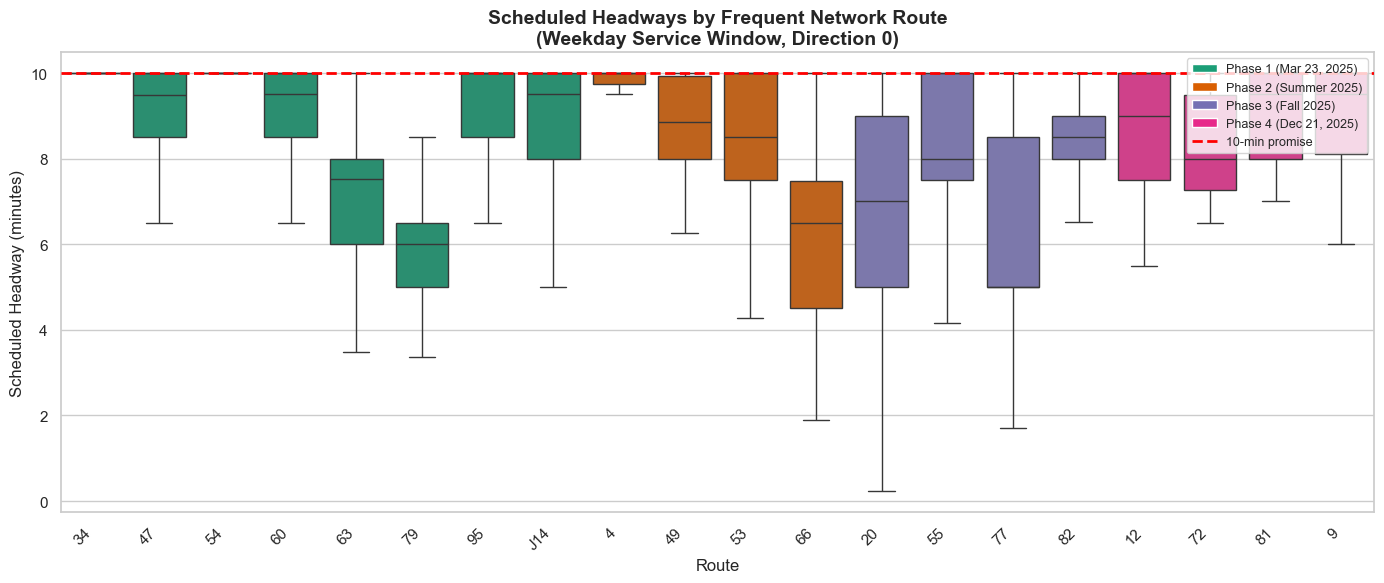

In [6]:
# Scheduled headway distribution plot: box plots grouped by phase
if scheduled_headways:
    # Build a long-form DataFrame for plotting
    plot_rows = []
    for route, hw in scheduled_headways.items():
        phase = get_phase_for_route(route)
        phase_num = phase.phase if phase else 0
        for val in hw:
            plot_rows.append({
                "Route": route,
                "Phase": phase_num,
                "Phase Label": phase.label if phase else "Unknown",
                "Headway (min)": val,
            })
    
    sched_plot_df = pd.DataFrame(plot_rows)
    
    # Sort routes by phase then route number for consistent ordering
    route_order = sorted(
        scheduled_headways.keys(),
        key=lambda r: (get_phase_for_route(r).phase if get_phase_for_route(r) else 99, r)
    )
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Create box plot
    phase_palette = {r: PHASE_COLORS[get_phase_for_route(r).phase]
                     for r in route_order if get_phase_for_route(r)}
    
    sns.boxplot(
        data=sched_plot_df,
        x="Route",
        y="Headway (min)",
        order=route_order,
        palette=phase_palette,
        showfliers=False,
        ax=ax,
    )
    
    # Add the 10-minute promise line
    ax.axhline(y=PROMISE_MINUTES, color="red", linestyle="--", linewidth=2,
               label=f"{PROMISE_MINUTES}-min promise", zorder=5)
    
    ax.set_title("Scheduled Headways by Frequent Network Route\n(Weekday Service Window, Direction 0)",
                 fontsize=14, fontweight="bold")
    ax.set_xlabel("Route", fontsize=12)
    ax.set_ylabel("Scheduled Headway (minutes)", fontsize=12)
    ax.legend(fontsize=11, loc="upper right")
    
    # Add phase legend
    from matplotlib.patches import Patch
    phase_patches = [Patch(facecolor=PHASE_COLORS[p.phase], label=p.label)
                     for p in FREQUENT_NETWORK_PHASES]
    phase_patches.append(plt.Line2D([0], [0], color="red", linestyle="--", linewidth=2,
                                     label=f"{PROMISE_MINUTES}-min promise"))
    ax.legend(handles=phase_patches, loc="upper right", fontsize=9)
    
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("No scheduled headway data to plot.")

---

## Part 2: Observed Headways (Bus Tracker Data)

Now we look at what actually happened on the street. Our headway collector polls the CTA Bus Tracker API and stores vehicle positions in `data/headway.db`. We use the `pdist` field (distance along route in feet) to detect when buses pass a reference point, then compute the time gaps between consecutive buses.

**Note:** If the collector has only been running briefly, the data may be sparse. We flag this and provide guidance on how much data is needed for robust analysis.

In [7]:
# Load collected data from SQLite
has_observed = DB_PATH.exists()

if has_observed:
    conn = sqlite3.connect(str(DB_PATH))
    
    # Overall summary
    summary = pd.read_sql("""
        SELECT 
            COUNT(*) as total_positions,
            COUNT(DISTINCT collected_at) as polls,
            COUNT(DISTINCT route) as routes,
            COUNT(DISTINCT vid) as vehicles,
            MIN(collected_at) as first_poll,
            MAX(collected_at) as last_poll
        FROM vehicle_positions
    """, conn)
    
    print("Collected Vehicle Position Data Summary")
    print("=" * 60)
    print(summary.to_string(index=False))
    
    # Calculate collection duration
    if summary["total_positions"].iloc[0] > 0:
        first = pd.to_datetime(summary["first_poll"].iloc[0])
        last = pd.to_datetime(summary["last_poll"].iloc[0])
        duration = last - first
        print(f"\nCollection duration: {duration}")
        
        if duration.total_seconds() < 3600:
            print("\n*** LIMITED DATA WARNING ***")
            print("Less than 1 hour of data collected.")
            print("Headway estimates will be rough. Continue collecting for 2+ weeks")
            print("for statistically meaningful results.")
        elif duration.total_seconds() < 86400:
            print(f"\nData covers ~{duration.total_seconds()/3600:.1f} hours.")
            print("This is enough for initial exploration but not for robust conclusions.")
    else:
        print("\nNo vehicle positions collected yet. Run the headway collector first:")
        print("  uv run python -m bus_check.collector.headway_collector")
else:
    conn = None
    print("Database not found at", DB_PATH)
    print("Run the headway collector first:")
    print("  uv run python -m bus_check.collector.headway_collector")

Collected Vehicle Position Data Summary
 total_positions  polls  routes  vehicles                       first_poll                        last_poll
          140419    446      20       816 2026-02-11T21:57:17.384147+00:00 2026-02-12T14:40:10.803004+00:00

Collection duration: 0 days 16:42:53.418857

Data covers ~16.7 hours.
This is enough for initial exploration but not for robust conclusions.


In [8]:
# Data by route summary: positions and unique vehicles per route
if has_observed and conn and summary["total_positions"].iloc[0] > 0:
    route_summary = pd.read_sql("""
        SELECT 
            route,
            COUNT(*) as positions,
            COUNT(DISTINCT vid) as unique_vehicles,
            COUNT(DISTINCT collected_at) as polls,
            MIN(collected_at) as first_seen,
            MAX(collected_at) as last_seen,
            MIN(pdist) as min_pdist,
            MAX(pdist) as max_pdist
        FROM vehicle_positions
        GROUP BY route
        ORDER BY positions DESC
    """, conn)
    
    print(f"Data collected for {len(route_summary)} routes:")
    print("=" * 100)
    display(route_summary)
    
    # Check coverage of FN routes
    collected_routes = set(route_summary["route"].tolist())
    fn_collected = [r for r in ALL_FREQUENT_ROUTES if r in collected_routes]
    fn_not_collected = [r for r in ALL_FREQUENT_ROUTES if r not in collected_routes]
    
    print(f"\nFrequent Network route coverage: {len(fn_collected)}/{len(ALL_FREQUENT_ROUTES)}")
    if fn_not_collected:
        print(f"Missing FN routes: {fn_not_collected}")
else:
    print("No observed data to summarize.")

Data collected for 20 routes:


,route,positions,unique_vehicles,polls,first_seen,last_seen,min_pdist,max_pdist
0,53,11497,68,446,2026-02-11T21:57:17.384147+00:00,2026-02-12T14:40:10.803004+00:00,0,90813
1,79,10219,62,412,2026-02-11T21:57:17.384147+00:00,2026-02-12T14:40:10.803004+00:00,0,61823
2,9,10101,61,446,2026-02-11T21:57:17.384147+00:00,2026-02-12T14:40:10.803004+00:00,0,103261
3,66,9679,74,446,2026-02-11T21:57:17.384147+00:00,2026-02-12T14:40:10.803004+00:00,0,53016
4,77,9562,70,446,2026-02-11T21:57:17.384147+00:00,2026-02-12T14:40:10.803004+00:00,0,57659
5,82,8398,55,446,2026-02-11T21:57:17.384147+00:00,2026-02-12T14:40:10.803004+00:00,0,68662
6,4,8088,50,412,2026-02-11T21:57:17.384147+00:00,2026-02-12T14:40:10.803004+00:00,0,80595
7,49,7941,86,412,2026-02-11T21:57:17.384147+00:00,2026-02-12T14:40:10.803004+00:00,0,83898
8,20,7258,50,446,2026-02-11T21:57:17.384147+00:00,2026-02-12T14:40:10.803004+00:00,0,45332
9,72,6998,45,446,2026-02-11T21:57:17.384147+00:00,2026-02-12T14:40:10.803004+00:00,0,49108



Frequent Network route coverage: 20/20


In [9]:
# Detect stop arrivals and compute observed headways for each FN route
# For each route, pick a reference pdist at the midpoint of the observed range,
# then detect when buses cross that point and compute time gaps.

observed_headways = {}
arrival_data = {}

if has_observed and conn and summary["total_positions"].iloc[0] > 0:
    for route in ALL_FREQUENT_ROUTES:
        if route not in collected_routes:
            continue
        
        # Load all positions for this route
        positions = pd.read_sql(
            "SELECT vid, tmstmp, pdist, route, direction FROM vehicle_positions WHERE route = ?",
            conn,
            params=[route],
        )
        
        if positions.empty or positions["pdist"].isna().all():
            print(f"  Route {route}: no pdist data")
            continue
        
        # Parse timestamps
        positions["tmstmp"] = pd.to_datetime(positions["tmstmp"])
        
        # Pick reference pdist at midpoint of observed range
        min_pdist = positions["pdist"].min()
        max_pdist = positions["pdist"].max()
        reference_pdist = int((min_pdist + max_pdist) / 2)
        
        # Detect arrivals at the reference point
        try:
            arrivals = detect_stop_arrivals(positions, reference_pdist, tolerance_feet=500)
            
            if len(arrivals) < 2:
                print(f"  Route {route}: only {len(arrivals)} arrival(s) detected (need >= 2)")
                continue
            
            # Ensure arrival_time is datetime
            arrivals["arrival_time"] = pd.to_datetime(arrivals["arrival_time"])
            
            # Compute headways
            headways = compute_headways_from_arrivals(arrivals)
            
            # Filter out extreme outliers (> 120 min likely means gap in collection)
            headways = headways[headways <= 120]
            
            if len(headways) > 0:
                observed_headways[route] = headways
                arrival_data[route] = arrivals
                print(f"  Route {route:>3s}: {len(arrivals):3d} arrivals, "
                      f"{len(headways):3d} headways, mean={headways.mean():.1f} min, "
                      f"ref_pdist={reference_pdist}")
            else:
                print(f"  Route {route}: headways computed but all filtered as outliers")
        except Exception as e:
            print(f"  Route {route}: error: {e}")
    
    print(f"\nObserved headways computed for {len(observed_headways)}/{len(ALL_FREQUENT_ROUTES)} routes.")
else:
    print("No observed data available for headway computation.")

  Route J14:  21 arrivals,  18 headways, mean=13.3 min, ref_pdist=42376


  Route  34:  21 arrivals,  17 headways, mean=13.2 min, ref_pdist=22240


  Route 47: only 0 arrival(s) detected (need >= 2)


  Route  54:  24 arrivals,  20 headways, mean=5.6 min, ref_pdist=21021


  Route  60:  37 arrivals,  34 headways, mean=9.1 min, ref_pdist=25197


  Route  63:  36 arrivals,  33 headways, mean=9.2 min, ref_pdist=23803


  Route  79:  48 arrivals,  46 headways, mean=7.7 min, ref_pdist=30911


  Route  95:  27 arrivals,  24 headways, mean=17.4 min, ref_pdist=25676


  Route   4:  38 arrivals,  35 headways, mean=8.3 min, ref_pdist=40297


  Route  49:  58 arrivals,  56 headways, mean=11.1 min, ref_pdist=41949


  Route  53:  56 arrivals,  54 headways, mean=12.1 min, ref_pdist=45406


  Route  66:  60 arrivals,  58 headways, mean=10.6 min, ref_pdist=26508


  Route  20:  43 arrivals,  41 headways, mean=14.1 min, ref_pdist=22666
  Route  55:  32 arrivals,  29 headways, mean=10.7 min, ref_pdist=25267


  Route  77:  59 arrivals,  56 headways, mean=9.1 min, ref_pdist=28829
  Route  82:  47 arrivals,  44 headways, mean=6.0 min, ref_pdist=34331


  Route   9:  33 arrivals,  30 headways, mean=11.4 min, ref_pdist=51630
  Route  12:  31 arrivals,  28 headways, mean=14.5 min, ref_pdist=23058
  Route  72:  42 arrivals,  39 headways, mean=10.2 min, ref_pdist=24554


  Route  81:  28 arrivals,  25 headways, mean=12.3 min, ref_pdist=16419

Observed headways computed for 19/20 routes.


In [10]:
# Compute headway metrics for each route and build a summary table
if observed_headways:
    metrics_rows = []
    for route, hw in observed_headways.items():
        phase = get_phase_for_route(route)
        metrics = compute_headway_metrics(hw)
        metrics_rows.append({
            "Route": route,
            "Phase": phase.phase if phase else "?",
            "N": len(hw),
            "Mean (min)": round(metrics["mean_headway"], 1),
            "Median (min)": round(metrics["median_headway"], 1),
            "Std (min)": round(metrics["std_headway"], 1),
            "CV": round(metrics["cv_headway"], 2),
            "Max (min)": round(metrics["max_headway"], 1),
            "% <= 10 min": round(metrics["pct_under_10"], 1),
            "% <= 12 min": round(metrics["pct_under_12"], 1),
            "% > 15 min": round(metrics["pct_over_15"], 1),
            "% > 20 min": round(metrics["pct_over_20"], 1),
            "Bunching %": round(metrics["bunching_rate"], 1),
            "EWT (min)": round(metrics["excess_wait_time"], 2),
        })
    
    obs_summary = pd.DataFrame(metrics_rows).sort_values("% <= 10 min", ascending=False)
    
    print("Observed Headway Metrics by Route")
    print("=" * 120)
    print("(Sorted by '% <= 10 min' -- higher is better)")
    print()
    display(obs_summary.reset_index(drop=True))
    
    # Highlight key findings
    best = obs_summary.iloc[0]
    worst = obs_summary.iloc[-1]
    print(f"\nBest performer:  Route {best['Route']} -- {best['% <= 10 min']}% of headways <= 10 min")
    print(f"Worst performer: Route {worst['Route']} -- {worst['% <= 10 min']}% of headways <= 10 min")
    print(f"Average across routes: {obs_summary['% <= 10 min'].mean():.1f}%")
else:
    print("No observed headway data available for metrics.")

Observed Headway Metrics by Route
(Sorted by '% <= 10 min' -- higher is better)



,Route,Phase,N,Mean (min),Median (min),Std (min),CV,Max (min),% <= 10 min,% <= 12 min,% > 15 min,% > 20 min,Bunching %,EWT (min)
0,54,1,20,5.6,5.5,4.7,0.83,16.0,90.0,90.0,5.0,0.0,25.0,1.84
1,82,3,44,6.0,4.0,8.1,1.35,50.0,86.4,90.9,6.8,2.3,27.3,5.38
2,72,4,39,10.2,4.0,19.8,1.95,92.0,84.6,87.2,12.8,10.3,23.1,18.82
3,79,1,46,7.7,3.0,12.9,1.67,75.0,82.6,87.0,8.7,6.5,19.6,10.54
4,77,3,56,9.1,5.0,17.2,1.88,88.0,82.1,85.7,12.5,8.9,30.4,15.88
5,53,2,54,12.1,4.0,22.5,1.86,106.0,81.5,85.2,13.0,13.0,16.7,20.59
6,66,2,58,10.6,4.0,18.9,1.78,112.0,75.9,79.3,15.5,12.1,20.7,16.53
7,63,1,33,9.2,4.0,12.7,1.37,60.0,72.7,81.8,15.2,12.1,18.2,8.40
8,55,3,29,10.7,6.0,17.7,1.66,96.0,72.4,75.9,17.2,6.9,17.2,14.16
9,81,4,25,12.3,6.0,17.5,1.43,80.0,72.0,80.0,20.0,16.0,8.0,12.00



Best performer:  Route 54 -- 90.0% of headways <= 10 min
Worst performer: Route 12 -- 57.1% of headways <= 10 min
Average across routes: 72.9%


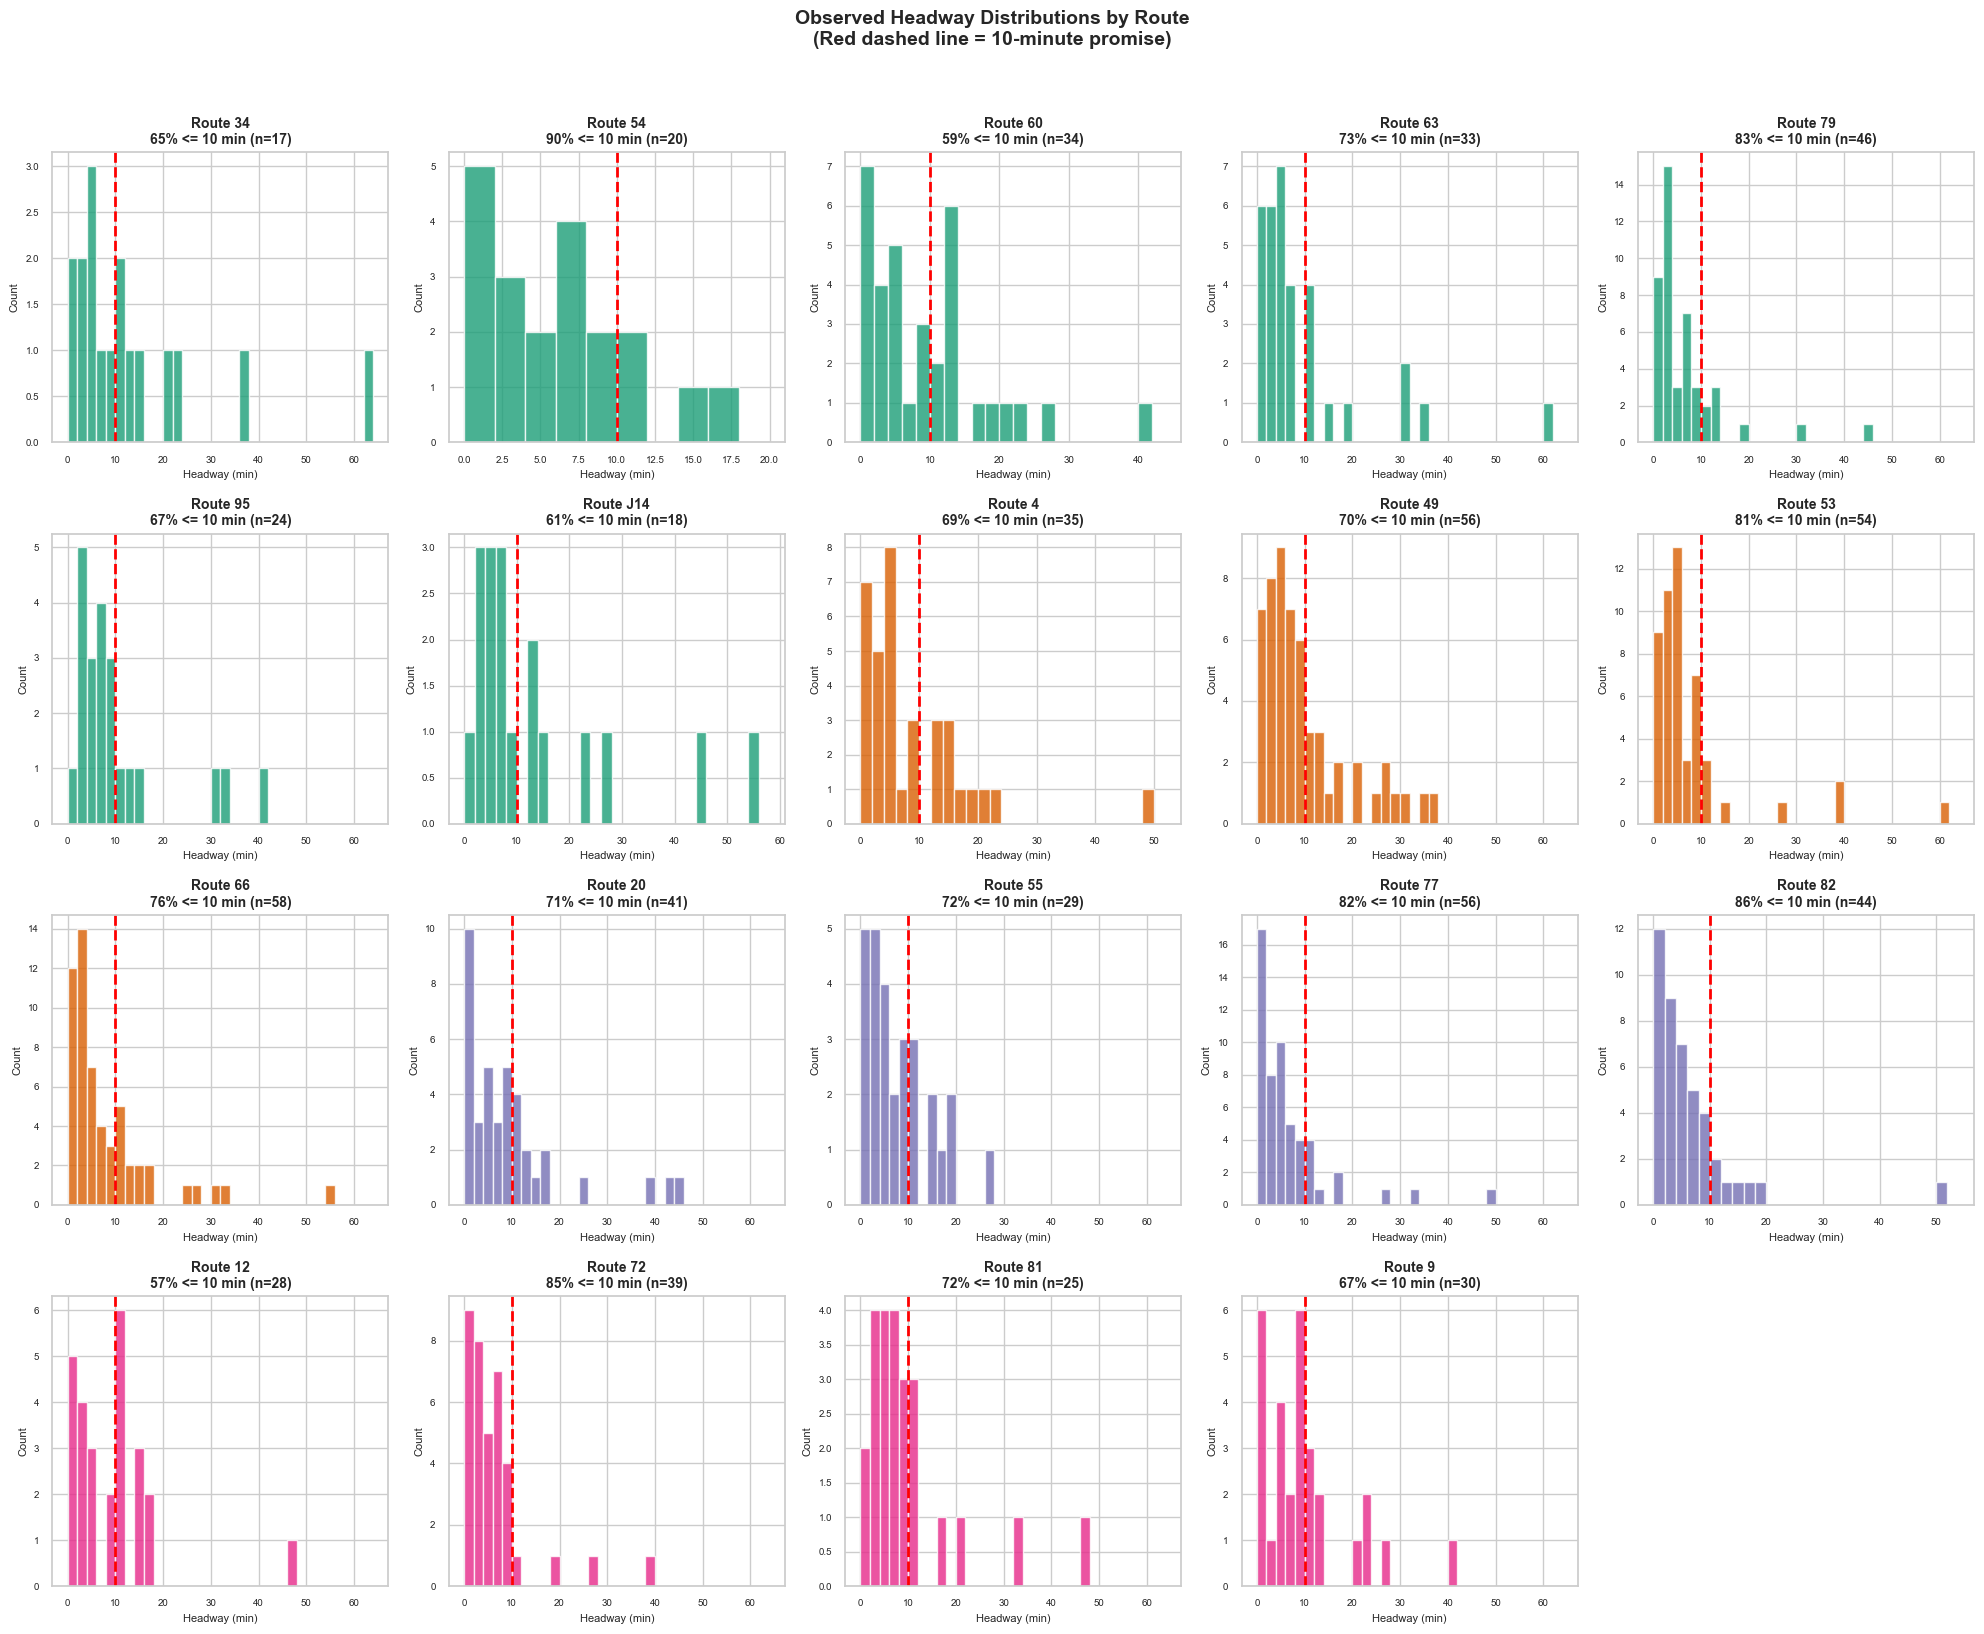

In [11]:
# Headway distribution histograms: small multiples (4x5 grid)
if observed_headways:
    n_routes = len(observed_headways)
    ncols = 5
    nrows = max(1, (n_routes + ncols - 1) // ncols)  # ceil division
    
    # Sort routes by phase then name
    sorted_routes = sorted(
        observed_headways.keys(),
        key=lambda r: (get_phase_for_route(r).phase if get_phase_for_route(r) else 99, r)
    )
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 4 * nrows), squeeze=False)
    
    for idx, route in enumerate(sorted_routes):
        row, col = divmod(idx, ncols)
        ax = axes[row][col]
        hw = observed_headways[route]
        phase = get_phase_for_route(route)
        color = PHASE_COLORS.get(phase.phase, "#999999") if phase else "#999999"
        pct = (hw <= PROMISE_MINUTES).mean() * 100
        
        ax.hist(hw, bins=np.arange(0, min(hw.max() + 5, 65), 2),
                color=color, edgecolor="white", alpha=0.8)
        ax.axvline(x=PROMISE_MINUTES, color="red", linestyle="--", linewidth=2)
        ax.set_title(f"Route {route}\n{pct:.0f}% <= {PROMISE_MINUTES} min (n={len(hw)})",
                     fontsize=10, fontweight="bold")
        ax.set_xlabel("Headway (min)", fontsize=8)
        ax.set_ylabel("Count", fontsize=8)
        ax.tick_params(labelsize=7)
    
    # Hide unused axes
    for idx in range(n_routes, nrows * ncols):
        row, col = divmod(idx, ncols)
        axes[row][col].set_visible(False)
    
    fig.suptitle("Observed Headway Distributions by Route\n"
                 f"(Red dashed line = {PROMISE_MINUTES}-minute promise)",
                 fontsize=14, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No observed headway data to plot.")

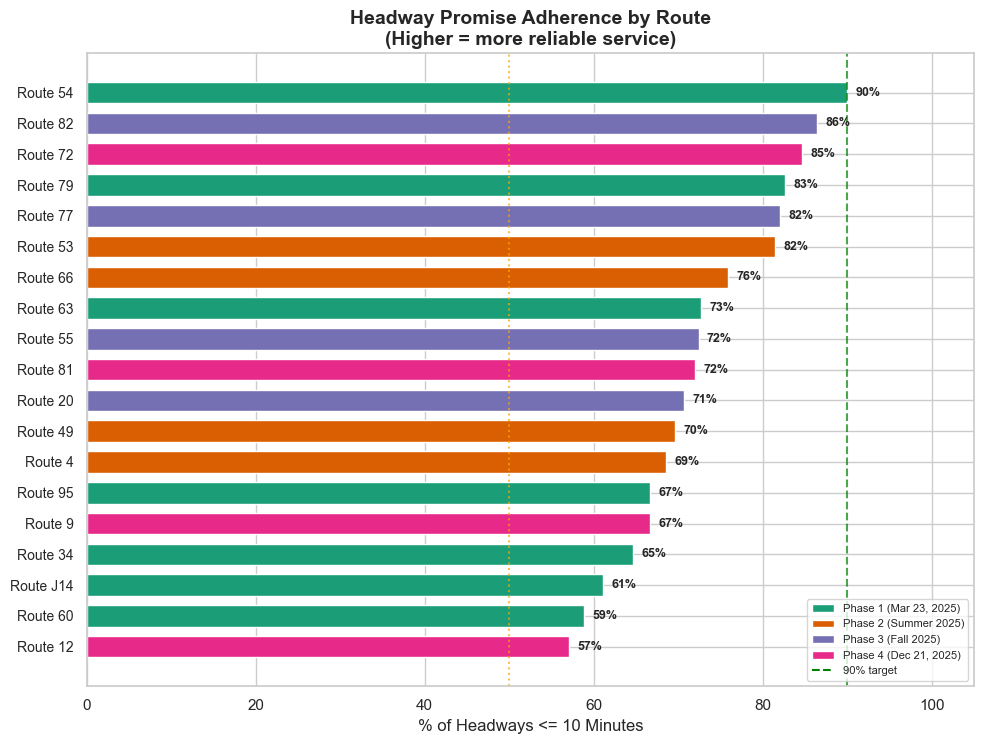

In [12]:
# Headway reliability by route: horizontal bar chart of % <= 10 min
if observed_headways:
    # Prepare data sorted by performance
    bar_data = obs_summary.sort_values("% <= 10 min", ascending=True).copy()
    
    fig, ax = plt.subplots(figsize=(10, max(6, len(bar_data) * 0.4)))
    
    # Color bars by phase
    colors = [PHASE_COLORS.get(
        get_phase_for_route(r).phase, "#999999"
    ) if get_phase_for_route(r) else "#999999" for r in bar_data["Route"]]
    
    bars = ax.barh(
        y=range(len(bar_data)),
        width=bar_data["% <= 10 min"],
        color=colors,
        edgecolor="white",
        height=0.7,
    )
    
    # Reference lines
    ax.axvline(x=90, color="green", linestyle="--", linewidth=1.5, alpha=0.7,
               label="90% target")
    ax.axvline(x=50, color="orange", linestyle=":", linewidth=1.5, alpha=0.7,
               label="50% baseline")
    
    # Labels
    ax.set_yticks(range(len(bar_data)))
    ax.set_yticklabels([f"Route {r}" for r in bar_data["Route"]], fontsize=10)
    ax.set_xlabel(f"% of Headways <= {PROMISE_MINUTES} Minutes", fontsize=12)
    ax.set_title("Headway Promise Adherence by Route\n"
                 "(Higher = more reliable service)",
                 fontsize=14, fontweight="bold")
    ax.set_xlim(0, 105)
    
    # Add value labels on bars
    for i, (val, route) in enumerate(zip(bar_data["% <= 10 min"], bar_data["Route"])):
        ax.text(val + 1, i, f"{val:.0f}%", va="center", fontsize=9, fontweight="bold")
    
    # Phase legend
    from matplotlib.patches import Patch
    handles = [Patch(facecolor=PHASE_COLORS[p.phase], label=p.label)
               for p in FREQUENT_NETWORK_PHASES]
    handles.append(plt.Line2D([0], [0], color="green", linestyle="--", label="90% target"))
    ax.legend(handles=handles, loc="lower right", fontsize=8)
    
    plt.tight_layout()
    plt.show()
else:
    print("No observed headway data to plot.")

---

## Part 3: Scheduled vs. Actual Comparison

The central question: **does reality match the timetable?**

If scheduled headways are already above 10 minutes, the promise was never backed by the schedule. If they are under 10 minutes but observed headways are worse, buses are running behind schedule. Either way, riders feel the gap.

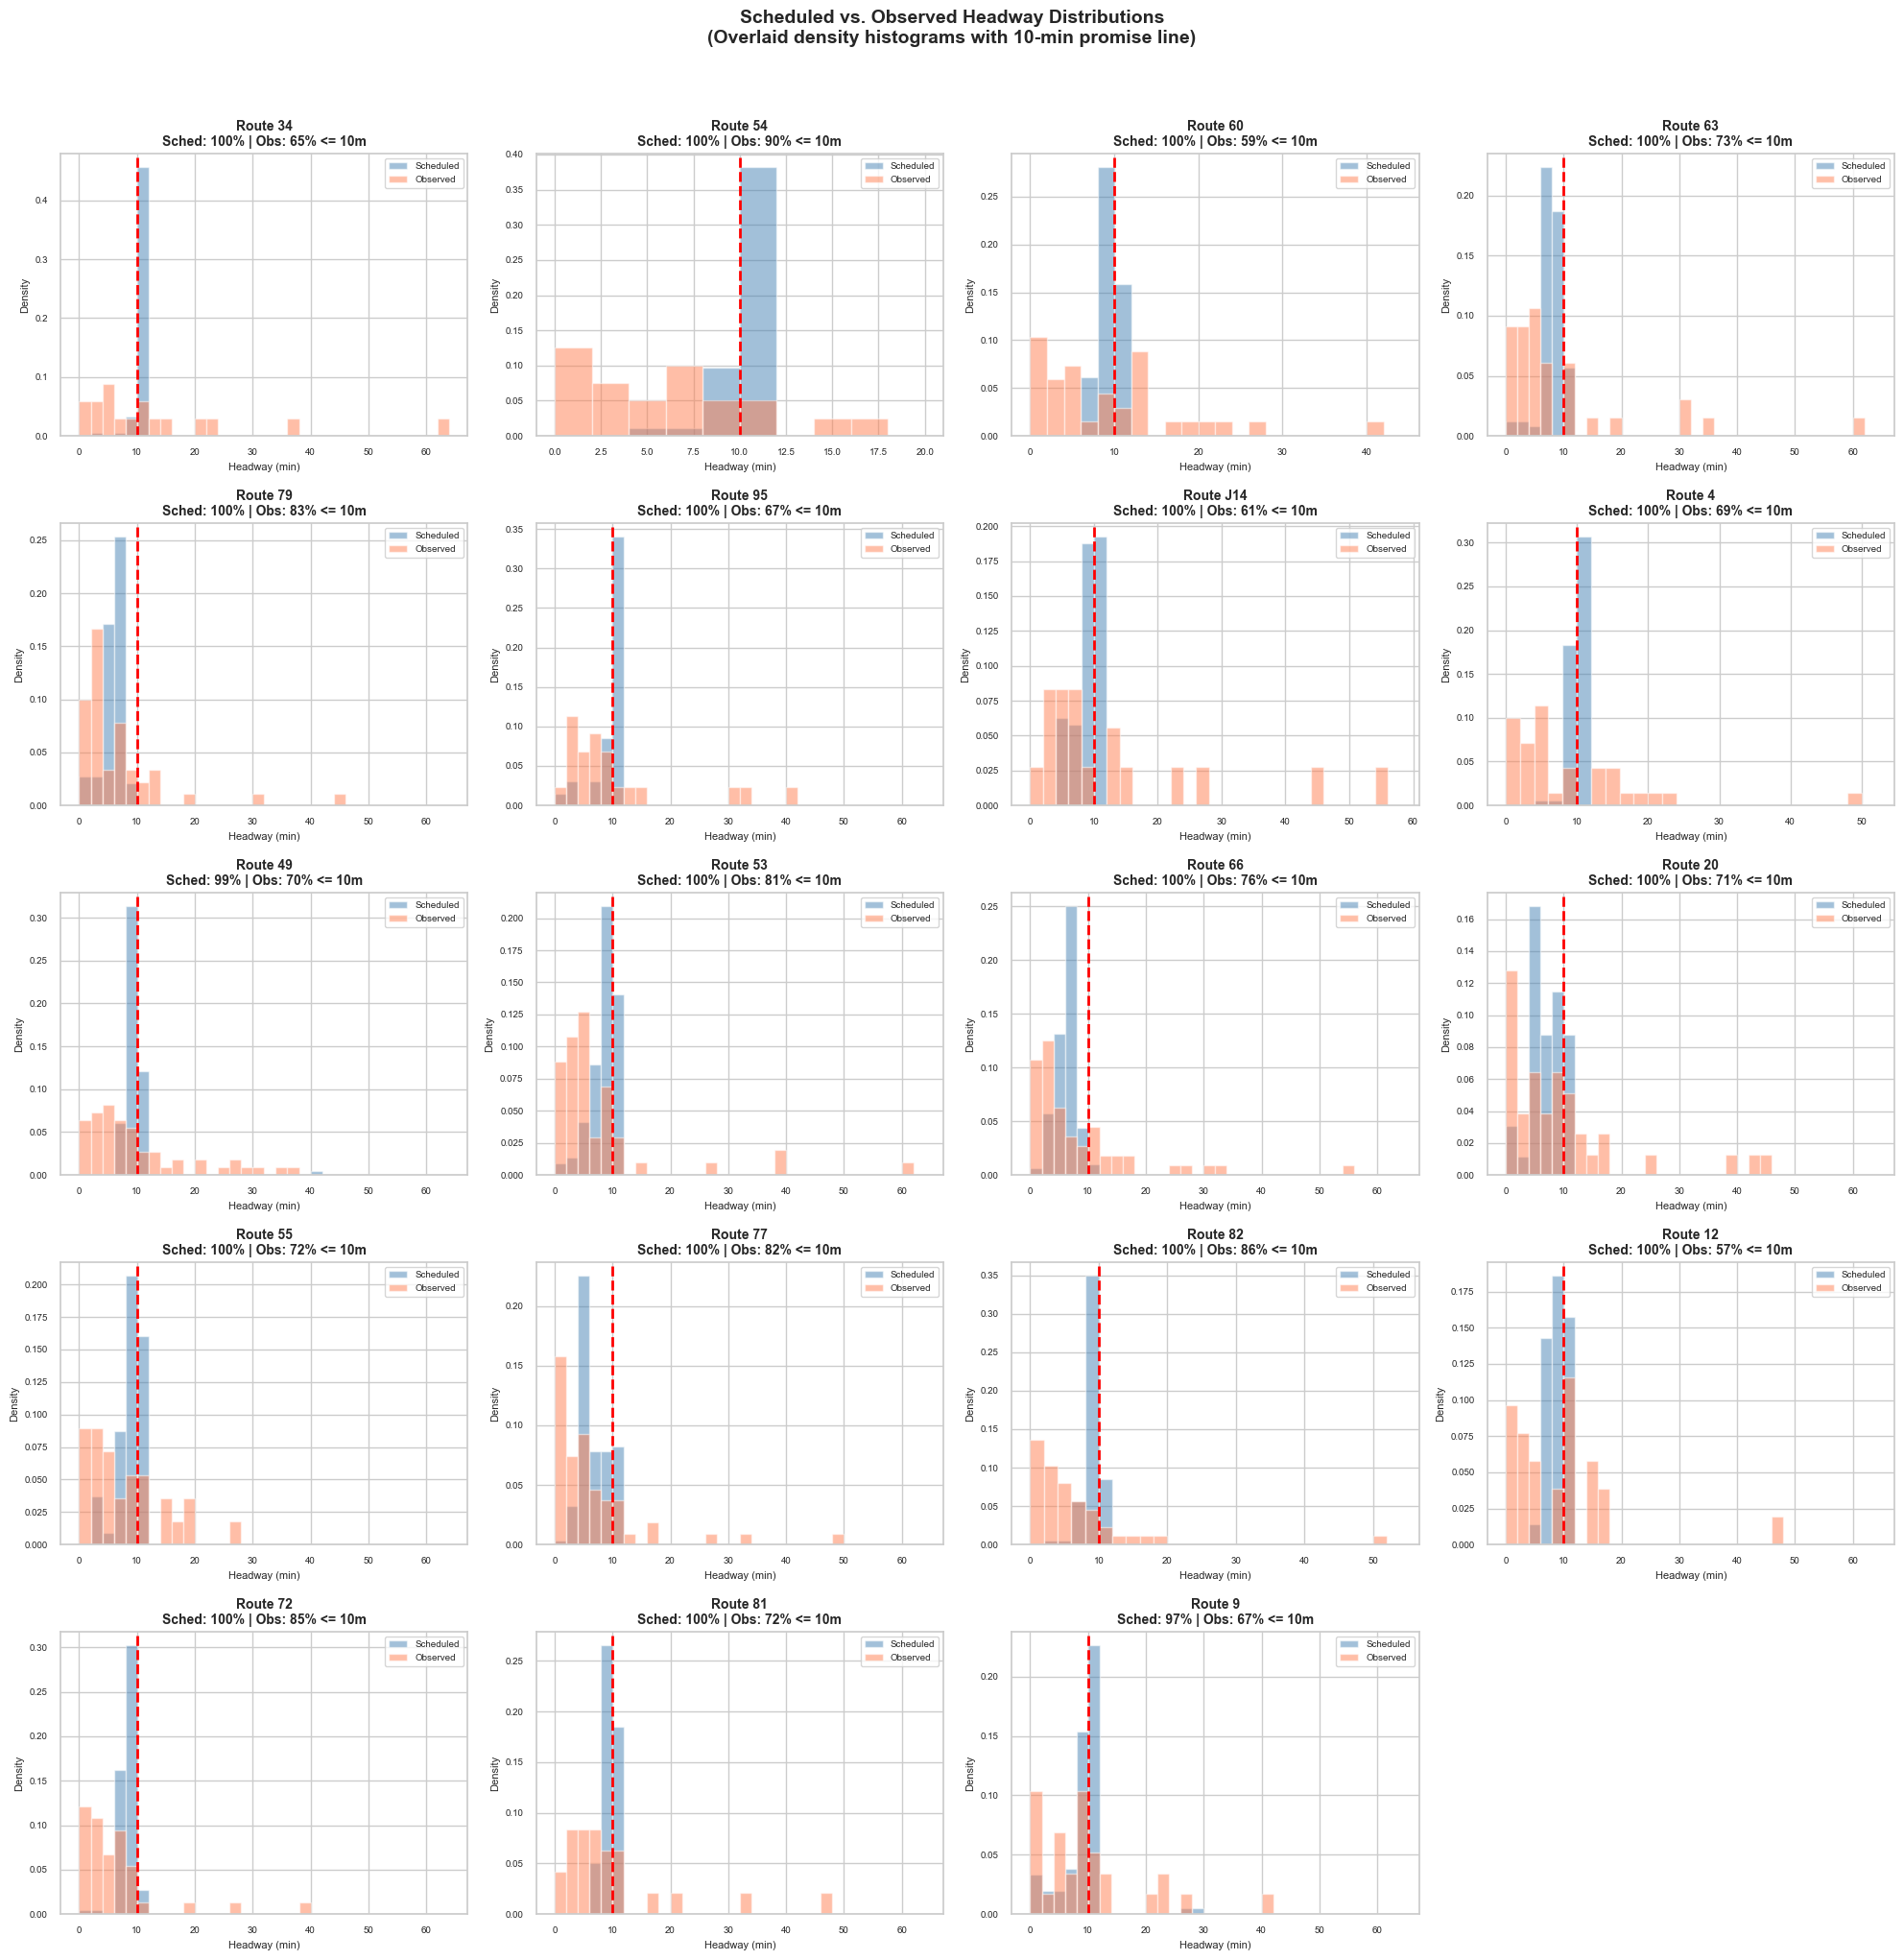


Scheduled vs. Observed Comparison
(Delta Mean > 0 means observed headways are LONGER than scheduled)


,Route,Phase,Sched Mean,Obs Mean,Delta Mean,Sched % <= 10,Obs % <= 10,Delta %
0,95,1,8.9,17.4,8.5,100.0,66.7,-33.3
1,20,3,6.8,14.1,7.3,100.0,70.7,-29.3
2,12,4,8.6,14.5,6.0,100.0,57.1,-42.9
3,J14,1,8.7,13.3,4.7,100.0,61.1,-38.9
4,66,2,6.1,10.6,4.5,100.0,75.9,-24.1
5,53,2,8.2,12.1,3.9,100.0,81.5,-18.5
6,34,1,9.8,13.2,3.4,100.0,64.7,-35.3
7,81,4,9.0,12.3,3.3,100.0,72.0,-28.0
8,9,4,8.7,11.4,2.7,97.1,66.7,-30.4
9,77,3,6.5,9.1,2.6,100.0,82.1,-17.9


In [13]:
# Side-by-side comparison: scheduled vs. observed headway distributions
# Only for routes where we have both data sources

both_routes = sorted(
    set(scheduled_headways.keys()) & set(observed_headways.keys()),
    key=lambda r: (get_phase_for_route(r).phase if get_phase_for_route(r) else 99, r)
)

if both_routes:
    n = len(both_routes)
    ncols = min(4, n)
    nrows = max(1, (n + ncols - 1) // ncols)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), squeeze=False)
    
    for idx, route in enumerate(both_routes):
        row, col = divmod(idx, ncols)
        ax = axes[row][col]
        
        sched = scheduled_headways[route]
        obs = observed_headways[route]
        
        # Use consistent bins
        max_val = max(sched.max(), obs.max())
        bins = np.arange(0, min(max_val + 5, 65), 2)
        
        ax.hist(sched, bins=bins, alpha=0.5, color="steelblue", label="Scheduled", density=True)
        ax.hist(obs, bins=bins, alpha=0.5, color="coral", label="Observed", density=True)
        ax.axvline(x=PROMISE_MINUTES, color="red", linestyle="--", linewidth=2)
        
        sched_pct = (sched <= PROMISE_MINUTES).mean() * 100
        obs_pct = (obs <= PROMISE_MINUTES).mean() * 100
        
        ax.set_title(f"Route {route}\nSched: {sched_pct:.0f}% | Obs: {obs_pct:.0f}% <= {PROMISE_MINUTES}m",
                     fontsize=10, fontweight="bold")
        ax.set_xlabel("Headway (min)", fontsize=8)
        ax.set_ylabel("Density", fontsize=8)
        ax.legend(fontsize=7)
        ax.tick_params(labelsize=7)
    
    # Hide unused
    for idx in range(n, nrows * ncols):
        row, col = divmod(idx, ncols)
        axes[row][col].set_visible(False)
    
    fig.suptitle("Scheduled vs. Observed Headway Distributions\n"
                 "(Overlaid density histograms with 10-min promise line)",
                 fontsize=14, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Summary comparison table
    comp_rows = []
    for route in both_routes:
        sched = scheduled_headways[route]
        obs = observed_headways[route]
        phase = get_phase_for_route(route)
        comp_rows.append({
            "Route": route,
            "Phase": phase.phase if phase else "?",
            "Sched Mean": round(sched.mean(), 1),
            "Obs Mean": round(obs.mean(), 1),
            "Delta Mean": round(obs.mean() - sched.mean(), 1),
            "Sched % <= 10": round((sched <= PROMISE_MINUTES).mean() * 100, 1),
            "Obs % <= 10": round((obs <= PROMISE_MINUTES).mean() * 100, 1),
            "Delta %": round(
                (obs <= PROMISE_MINUTES).mean() * 100 - (sched <= PROMISE_MINUTES).mean() * 100, 1
            ),
        })
    
    comp_df = pd.DataFrame(comp_rows).sort_values("Delta Mean", ascending=False)
    print("\nScheduled vs. Observed Comparison")
    print("(Delta Mean > 0 means observed headways are LONGER than scheduled)")
    print("=" * 90)
    display(comp_df.reset_index(drop=True))

elif not scheduled_headways:
    print("No scheduled headway data available (GTFS not downloaded).")
    print("Run the GTFS download cell above first.")
elif not observed_headways:
    print("No observed headway data available (collector data needed).")
    print("Run: uv run python -m bus_check.collector.headway_collector")
else:
    print("No routes with both scheduled and observed data.")

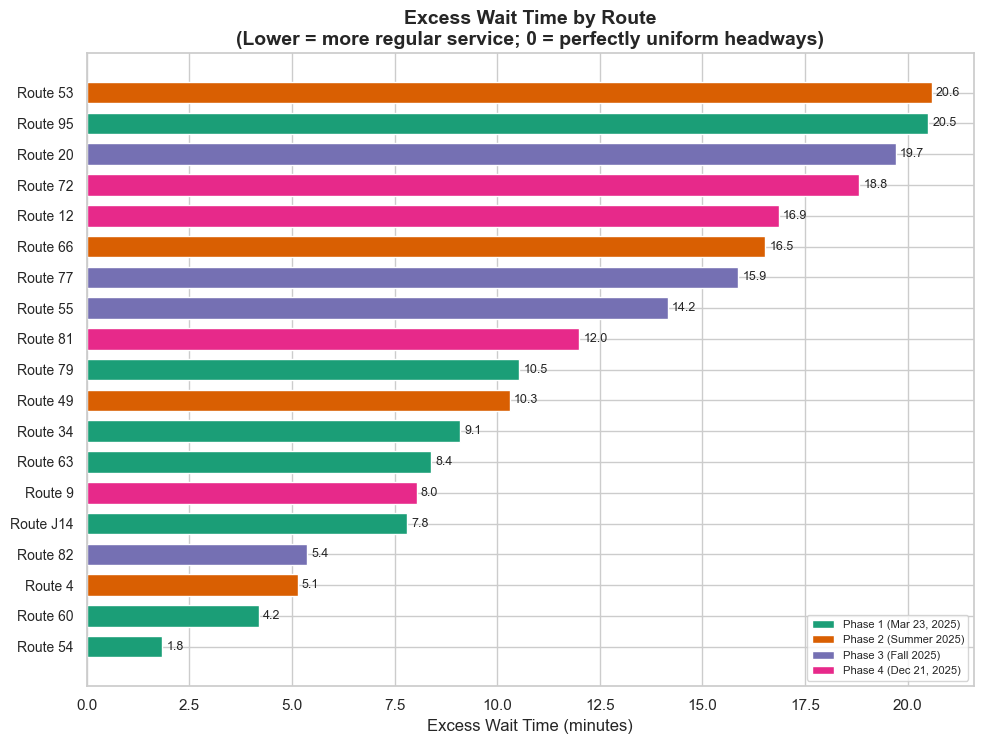


Excess Wait Time Summary


,Route,Phase,EWT (min),Mean Headway,CV,Sched EWT (min),EWT Penalty
0,54,1,1.84,5.6,0.83,0.04,1.81
1,60,1,4.20,9.1,0.97,0.05,4.14
2,4,2,5.14,8.3,1.13,0.02,5.12
3,82,3,5.38,6.0,1.35,0.07,5.31
4,J14,1,7.80,13.3,1.11,0.18,7.62
5,9,4,8.04,11.4,1.21,0.76,7.28
6,63,1,8.40,9.2,1.37,0.23,8.17
7,34,1,9.10,13.2,1.21,0.03,9.07
8,49,2,10.31,11.1,1.37,0.58,9.72
9,79,1,10.54,7.7,1.67,0.26,10.28



Average EWT penalty (observed - scheduled): 11.66 minutes


In [14]:
# Excess Wait Time (EWT) comparison across routes
# EWT measures extra time riders wait beyond what they would with perfectly even headways.
# A perfectly uniform 10-min service has EWT = 0. Higher = more irregular/unreliable.

if observed_headways:
    ewt_rows = []
    for route in sorted(
        observed_headways.keys(),
        key=lambda r: (get_phase_for_route(r).phase if get_phase_for_route(r) else 99, r)
    ):
        hw = observed_headways[route]
        metrics = compute_headway_metrics(hw)
        phase = get_phase_for_route(route)
        
        row = {
            "Route": route,
            "Phase": phase.phase if phase else "?",
            "EWT (min)": round(metrics["excess_wait_time"], 2),
            "Mean Headway": round(metrics["mean_headway"], 1),
            "CV": round(metrics["cv_headway"], 2),
        }
        
        # Add scheduled EWT if available
        if route in scheduled_headways:
            sched_metrics = compute_headway_metrics(scheduled_headways[route])
            row["Sched EWT (min)"] = round(sched_metrics["excess_wait_time"], 2)
            row["EWT Penalty"] = round(
                metrics["excess_wait_time"] - sched_metrics["excess_wait_time"], 2
            )
        
        ewt_rows.append(row)
    
    ewt_df = pd.DataFrame(ewt_rows).sort_values("EWT (min)", ascending=True)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, max(6, len(ewt_df) * 0.4)))
    
    colors = [PHASE_COLORS.get(
        get_phase_for_route(r).phase, "#999999"
    ) if get_phase_for_route(r) else "#999999" for r in ewt_df["Route"]]
    
    ax.barh(
        y=range(len(ewt_df)),
        width=ewt_df["EWT (min)"],
        color=colors,
        edgecolor="white",
        height=0.7,
    )
    
    ax.set_yticks(range(len(ewt_df)))
    ax.set_yticklabels([f"Route {r}" for r in ewt_df["Route"]], fontsize=10)
    ax.set_xlabel("Excess Wait Time (minutes)", fontsize=12)
    ax.set_title("Excess Wait Time by Route\n"
                 "(Lower = more regular service; 0 = perfectly uniform headways)",
                 fontsize=14, fontweight="bold")
    
    # Add value labels
    for i, val in enumerate(ewt_df["EWT (min)"]):
        ax.text(val + 0.1, i, f"{val:.1f}", va="center", fontsize=9)
    
    from matplotlib.patches import Patch
    handles = [Patch(facecolor=PHASE_COLORS[p.phase], label=p.label)
               for p in FREQUENT_NETWORK_PHASES]
    ax.legend(handles=handles, loc="lower right", fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Show table
    print("\nExcess Wait Time Summary")
    print("=" * 80)
    display(ewt_df.reset_index(drop=True))
    
    if "EWT Penalty" in ewt_df.columns:
        print(f"\nAverage EWT penalty (observed - scheduled): "
              f"{ewt_df['EWT Penalty'].mean():.2f} minutes")
else:
    print("No observed headway data available for EWT analysis.")

---

## Key Findings and Caveats

### What the data shows

**Scheduled headways (GTFS):**
- The GTFS analysis reveals whether CTA has actually scheduled enough trips to deliver 10-minute headways during the service window (6 AM -- 9 PM weekdays, 9 AM -- 9 PM weekends).
- Routes where even the *schedule* shows headways above 10 minutes are structurally unable to meet the Frequent Network promise.

**Observed headways (Bus Tracker):**
- Real-world headway adherence is typically worse than scheduled due to traffic, bunching, and missed trips.
- The `% <= 10 min` metric directly measures whether the 10-minute promise is being kept.
- Excess Wait Time (EWT) captures how *irregular* service is -- even if the mean headway is close to 10 minutes, high variability means some riders wait much longer.

### Caveats

1. **Data volume:** If the headway collector has only been running for minutes or hours, the observed headway estimates will be noisy. For robust conclusions, **2+ weeks of continuous collection** across multiple weekdays and weekends is recommended.

2. **pdist-based arrival detection:** We infer stop arrivals from the `pdist` (distance along route) field in vehicle position data. This is approximate -- the tolerance window (500 feet by default) may miss some arrivals or double-count others if a bus lingers near the reference point.

3. **Weekday vs. weekend:** This initial analysis does not separate weekday from weekend service. The Frequent Network promise differs between the two (6 AM vs. 9 AM start), so a proper analysis should stratify by day type.

4. **Direction:** We only analyze direction 0 for scheduled headways. A complete analysis would cover both directions, as headways can differ significantly.

5. **Service window filtering:** Observed headways are not yet filtered to the service window. Headways measured during early morning or late night (when the 10-minute promise does not apply) would inflate the gap metrics.

6. **Reference stop selection:** We pick a single midpoint reference per route. Different stops along the same route may experience different headway patterns (e.g., near terminals vs. mid-route).

### Recommendations

- **Continue data collection** for at least 2 weeks before drawing policy conclusions.
- **Add service-window filtering** to observed headways (restrict to 6 AM -- 9 PM weekday, 9 AM -- 9 PM weekend).
- **Stratify by day of week** to identify whether weekday vs. weekend performance differs.
- **Track trends over time** -- are headways improving as CTA adjusts to the Frequent Network program?
- **Compare against control routes** not in the Frequent Network to assess whether the program is actually changing behavior.

In [15]:
# Cleanup
if has_observed and conn:
    conn.close()
    print("Database connection closed.")

Database connection closed.
